In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy.random import normal
from scipy import constants
from commpy.utilities  import signal_power, upsample
from utils.dsp import firFilter, pulseShape, eyediagram, lowPassFIR
from utils.models import mzm
from numpy.fft import fft, ifft, fftshift, fftfreq

In [17]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [18]:
figsize(10, 3)

# Comunicações Ópticas

# Detecção de sinais ópticos e ruído


<img src="./figuras/Rx_OOK.png" width="400">

## Fontes de ruído em receptores ópticos


Ruídos são distorções aleatórias e indesejáveis que afetam os sinais que carregam informação, dificultando ou impossibilitando o processo de comunicação. Para analisarmos o desempenho de um dado sistemas de comunicações é necessário que todas as fontes de ruído presentes no mesmo estejam caracterizadas. No caso de receptores em sistemas de comunicações ópticas, duas fontes de ruído são importantes: o ruído de disparo gerado no processo de fotodetecção e o ruído térmico dos componentes eletrônicos.

### Ruído de disparo (ou ruído balístico)

A corrente $I(t)$ gerada pela conversão da potência de sinal óptico incidente no fotodiodo pode ser escrita como

$$
\begin{equation}\label{eq1}
I(t)=I_{p}(t) + i_{s}(t)
\end{equation}
$$

em que $i_{s}(t)$ representa um processo aleatório conhecido como ruído de disparo e $I_{p}(t)$ corresponde à corrente proporcional à responsividade e à potência óptica incidente no fotodiodo, data por

$$
\begin{equation}\label{eq2}
I_{p}(t)=R_{d} P_{\text {in}}(t).
\end{equation}
$$

O ruído de disparo $i_{s}(t)$ é bem caracterizado como um processo aleatório estacionário com estatística de Poisson que, em geral, é aproximada por uma estatística gaussiana, o que facilita o seu tratamento matemático.

Seja $R_{i_s}(\tau)$ a função de autocorrelação de $i_s(t)$ será dada por

$$
\begin{equation} \label{eq3}
R_{i_s}(\tau) = E\left[i_s(t)i_s(t+\tau)\right].
\end{equation}
$$

Pelo teorema de Wiener-Kinchin, a densidade espectral e potência $S_{i_s}(f)$ associada a $i_s(t)$ é dada pela transformada de Fourier de $R_{i_s}(\tau)$, de modo que 

$$
\begin{align}
S_{i_s}(f)    &= \int_{-\infty}^{\infty}R_{i_s}(\tau)e^{-2\pi f \tau} d\tau\nonumber \\
R_{i_s}(\tau) &= \int_{-\infty}^{\infty}S_{i_s}(f)e^{2\pi f \tau} df\label{eq4}
\end{align}
$$

No caso do ruído de disparo, a densidade espectral de potência é constante e dada por $S_{i_s}(f)=q\bar{I}_p$, em que 
$\bar{I}_p$ é o valor médio da fotocorrente, definido por

$$
\begin{equation}\label{eq5}
\bar{I}_p = \frac{1}{T_s} \int_{-T_s/2}^{T_s/2}E[I_p(t)]dt.
\end{equation}
$$

em que $T_s$ é o período de sinalização da transmissão.

### Potência do ruído de disparo

A potência do ruído de disparo corresponderá a sua variância $\sigma_{s}^{2}$. Seja $B$ a banda do receptor óptico em $Hz$, $\sigma_{s}^{2}$ pode ser calculada por

$$
\begin{align}
\sigma_{s}^{2} &= E\left[i_{s}^{2}(t)\right] = R_{i_s}(0) \nonumber\\
               &= \int_{-\infty}^{\infty} S_{i_s}(f) df = \int_{-B}^{B} S_{i_s}(f) df \nonumber \\
               &= 2 q \bar{I}_{p} B \label{eq6}
\end{align}
$$

Uma vez que a corrente de escuro $I_d$ do fotodiodo (*dark current*) também contribui para o ruído de disparo, a mesma deve ser incluída em (\ref{eq6}), de modo que a expressão final para a variância do ruído de disparo será dada por

$$
\begin{equation}\label{eq7}
\sigma_{s}^{2} = 2 q (\bar{I}_{p} + I_d) B.
\end{equation}
$$


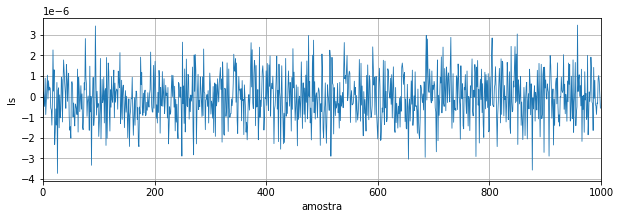

In [62]:
Pin_dBm = -1   # potência óptica média em dBm
Rd  = 0.5      # responsividade em A/W
Id  = 100e-9   # corrente de escuro em nA
B   = 10e9     # banda do receptor em Hz

q  = constants.value('elementary charge') # carga elementar do elétron

Pin = 10**(Pin_dBm/10)*1e-3 # potência óptica média em W
Ip  = Rd*Pin

# ruído de disparo (ruído gaussiano branco)
Namostras = 100000

σ2_s = 2*q*(Ip + Id)*B  # variância
μ    = 0                # média

σ     = np.sqrt(σ2_s) 
Is    = normal(μ, σ, Namostras)  

# plotas as primeiras 1000 amostras
plt.plot(Is[0:1000],linewidth = 0.8);
plt.xlim(0,1000)
plt.ylabel('Is')
plt.xlabel('amostra')
plt.grid()

In [20]:
# fdp de uma variável aleatória gaussiana de média μ e desvio padrão σ
def gaussian(x, μ, σ):
    return np.exp(-((x - μ)**2)/(2*σ**2))/np.sqrt(2*np.pi*σ**2)

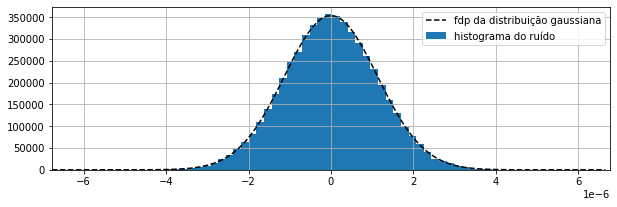

In [25]:
plt.hist(Is,51, density=True, label = 'histograma do ruído');
plt.grid()

x   = np.arange(-6*σ,6*σ, σ/10)
fdp = gaussian(x,μ,σ)

plt.plot(x,fdp,'k--',label ='fdp da distribuição gaussiana');
plt.legend();
plt.xlim(-6*σ,6*σ);

<IPython.core.display.Math object>

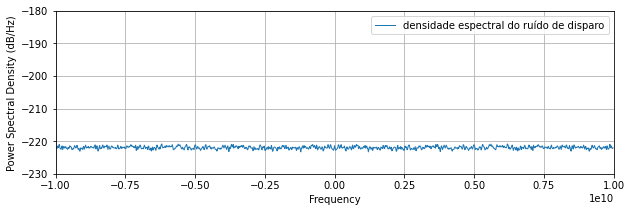

In [63]:
fa = 20e9   # frequência de amostragem considerada

plt.figure()
plt.xlim(-fa/2, fa/2)
plt.ylim(-230, -180)
plt.psd(Is, Fs=fa, label='densidade espectral do ruído de disparo',\
                   linewidth=1,  sides='twosided', NFFT=1024); # estima densidade espectral de potência do sinal
plt.legend()

display(Math('S_{i_s}(f) = %.2f \;\mathrm{dBW/Hz}'%(10*np.log10(σ2_s/(2*B)))))

#### Calculando a potência de um sinal

$$\begin{equation}\label{eq8}
P_x = E\left[X^2\right] = \mu^2 + \sigma^2\approx \frac{1}{N}\sum_{k=1}^{N} x^2[k]
\end{equation}
$$

In [27]:
Pn = signal_power(Is)

print('Potência do ruído (em W)   = %.2e W' %Pn) 
print('Potência do ruído (em dBm) = %.2f dBm' %(10*np.log10(Pn/1e-3))) 

Potência do ruído (em W)   = 1.27e-12 W
Potência do ruído (em dBm) = -88.96 dBm


### Ruído térmico

O ruído térmico tem sua origem na agitação térmica dos elétrons presentes no material que constitui um determinado dispositivo eletrônico submetido a uma dada temperatura. Desse modo, os circuitos eletrônicos que compõem o *front-end* dos receptores em sistemas de comunicação naturalmente adicionam ruído térmico aos sinais detectados. Portanto, num receptor óptico, os circuitos microeletrônicos responsáveis por processar o sinal elétrico obtido no processo de fotodetecção também serão fontes de ruído térmico.

Assim como o ruído de disparo, o ruído térmico tem características additivas e pode ser modelado por um processo aleatório gaussiano estacionário. Logo, podemos reescrever a equação (\ref{eq1}) adicionando a componente de ruído térmico $i_{T}(t)$, de modo que

$$
\begin{equation}\label{eq9}
I(t)=I_{p}+i_{s}(t)+i_{T}(t)
\end{equation}
$$

A densidade espectral de potência $S_{T}(f)$ do ruído térmico é constante e independente da frequência até $\sim 1 \mathrm{THz}$ e dada por

$$
\begin{equation}\label{eq10}
S_{T}(f) =2 k_{B} T/R_{L}
\end{equation}
$$

em que $k_B$ é a constante Boltzmann, $T$ é a temperatura na escala Kelvin e $R_L$ é o resistor de carga.

### Potência de ruído térmico

Novamente fazendo uso das propriedades da densidade espectral de potência, temos

$$
\begin{align}
\sigma_{T}^{2} &=E\left[ i_{T}^{2}(t)\right]\nonumber\\
               &=\int_{-\infty}^{\infty} S_{T}(f) df\nonumber\\
               &=\int_{-B}^{B} S_{T}(f) df\nonumber\\
               &=\left(4 k_{B} T / R_{L}\right) B\label{eq11}
\end{align}
$$

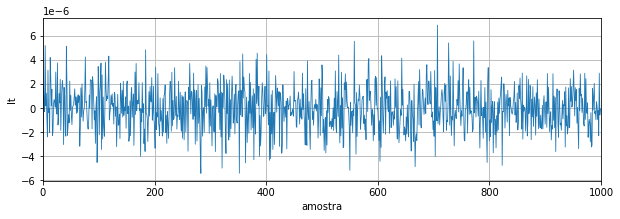

In [28]:
Tc = 25           # temperatura em Celsius
B  = 10e9         # banda do receptor
RL = 50           # RL em Ohms

T = Tc + 273.15   # temperatura em Kelvin


kB  = constants.value('Boltzmann constant')

# ruído térmico (ruído gaussiano branco)
Namostras = 100000

σ2_T = 4*kB*T*B/RL  # variância
μ    = 0            # média

σ     = np.sqrt(σ2_T) 
It    = normal(μ, σ, Namostras)  

# plotas as primeiras 1000 amostras
plt.plot(It[0:1000],linewidth = 0.8);
plt.xlim(0,1000)
plt.ylabel('It')
plt.xlabel('amostra')
plt.grid()

<IPython.core.display.Math object>

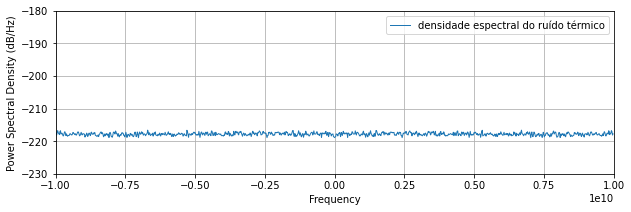

In [29]:
fa = 20e9   # frequência de amostragem considerada

plt.figure()
plt.xlim(-fa/2, fa/2)
plt.ylim(-230, -180)
plt.psd(It, Fs=fa, label='densidade espectral do ruído térmico',linewidth=1,  sides='twosided', NFFT=1024); # estima densidade espectral do sinal
plt.legend()

display(Math('S_{i_T}(f) = %.2f \;\mathrm{dBW/Hz}'%(10*np.log10(σ2_T/(2*B)))))

In [30]:
Pn = signal_power(It)

print('Potência do ruído (em W)   = %.2e W' %Pn) 
print('Potência do ruído (em dBm) = %.2f dBm' %(10*np.log10(Pn/1e-3))) 

Potência do ruído (em W)   = 3.29e-12 W
Potência do ruído (em dBm) = -84.83 dBm


Amplificadores elétricos utilizados em receptores ópticos invariavelmente adicionam ruído aos sinais sendo amplificados. O efeito da adição de ruído térmico no processo de amplificação é genericamente caracterizado pelo parâmetro de *figura de ruído* $F_n$ do dispositivo, de modo que

$$
\begin{equation}\label{eq12}
\sigma_{T}^{2}= \left(4 k_{B}T/ R_{L}\right) F_{n} B
\end{equation}
$$

O ruído total $i_n(t)$ adicionado pelo receptor será dado por $i_n(t) = i_s(t) + i_T(t)$, de modo que

$$
\begin{equation}\label{eq13}
\sigma_n^{2}=E\left[I_n^{2}\right]=\sigma_{s}^{2}+\sigma_{T}^{2}=2 q\left(\bar{I}_{p}+I_{d}\right) B +\left(4 k_{B}T/ R_{L}\right) F_{n} B
\end{equation}
$$

## Razão sinal-ruído (*signal-to-noise ratio* - SNR)

A relação sinal-ruído (ou razão sinal-ruído, *signal-to-noise ratio* (SNR), em Inglês) é uma das grandezas mais importantes na engenharia de sistemas de comunicações. A SNR é uma medida da influência do ruído num dado sistema.

A SNR é definida como sendo a razão entre a potência de sinal $P_s$ e a potência do ruído $P_n$ observadas num dado sistema, ou seja

$$
\begin{equation}\label{eq14}
\mathrm{SNR} = \frac{P_s}{P_n}
\end{equation}
$$

em que $P_s = E\left[|s(t)|^2\right]$ e $P_n=E\left[|n(t)|^2\right]$.

Quando expressa em decibéis (dB), a SNR é dada por

$$ 
\begin{equation}\label{eq15}
\mathrm{SNR}_{dB} = 10\log_{10}P_s-10\log_{10}P_n.
\end{equation}
$$

Quanto maior a SNR maior a diferença entre a potência do sinal de interesse e a potência do ruído adicionado á mesma. Dessa forma, quanto maior a SNR melhor a qualidade do sinal.

### Receptores p-i-n

Para receptores p-i-n, considerando a presença de ruído de disparo e ruído térmico, temos a seguinte expressão para a SNR do sinal elétrico na saída do fotodiodo

$$
\begin{equation}
\mathrm{SNR}=\frac{R_{d}^{2} P_{i n}^{2}}{2 q\left(R_{d} P_{i n}+I_{d}\right)B + 4\left(k_{B} T / R_{L}\right) F_{n} B}.
\end{equation}
$$

### Simulando o transmissor 10G OOK

Potência média do sinal óptico modulado (mW): 0.01 mW
Potência média do sinal óptico modulado (dBm): -20.01 dBm


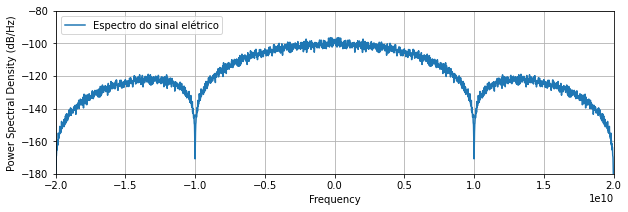

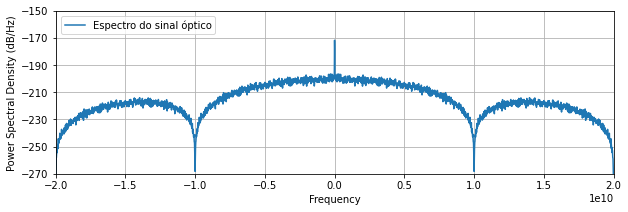

In [54]:
# parâmetros da simulação
SpS = 16

Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

Pi_dBm = -17  # potência de sinal óptico em dBm

# parâmetros do modulador
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bits-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulação óptica
Ai     = np.sqrt(Pi)
sigTxo = mzm(Ai, Vπ, sigTx, Vb)

print('Potência média do sinal óptico modulado (mW): %.2f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado (dBm): %.2f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

# plota psd
plt.figure();
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-180,-80);
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
plt.legend(loc='upper left');

# plota psd
plt.figure();
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-270,-150);
plt.psd(np.abs(sigTxo)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
plt.legend(loc='upper left');

### Simulando as fontes de ruído do receptor p-i-n

Pin[Rx] = -20.01 dBm 
SNR[teoria] = 16.10 dB 
SNR[sim] = 16.03 dB 


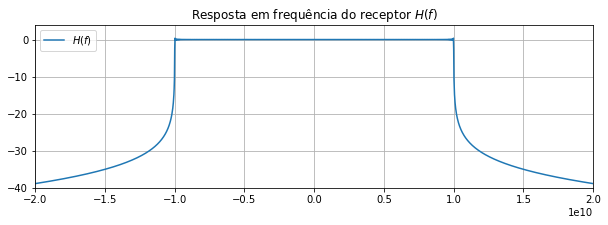

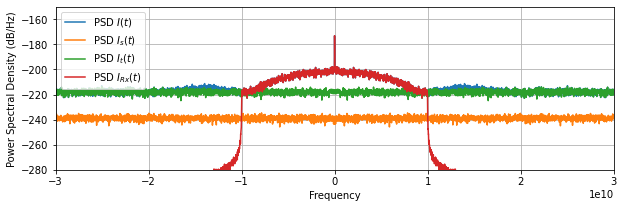

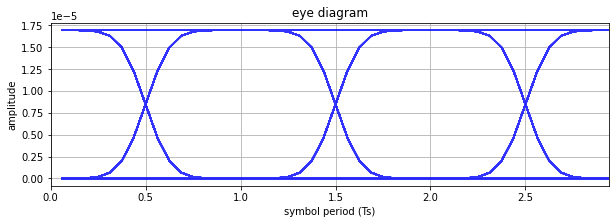

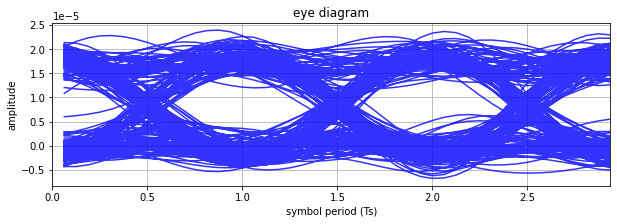

In [60]:
# parâmetros do receptor
Tc  = 25        # temperatura em Celsius
B   = 10e9     # banda do receptor em Hz
Rd  = 0.85      # responsividade em A/W
Id  = 5e-9      # corrente de escuro em nA
RL  = 50        # RL em Ohms

Pin = (np.abs(sigTxo)**2).mean() # Potência óptica média média recebida

# fotocorrente livre de ruído
Ip = Rd*np.abs(sigTxo)**2

# ruído de disparo 
σ2_s = 2*q*(Rd*Pin + Id)*B  # variância  

# ruído térmico
T = Tc + 273.15     # temperatura em Kelvin
σ2_T = 4*kB*T*B/RL  # variância do ruído térmico

# adiciona ruído do receptor p-i-n aos sinais
Is   = normal(0, np.sqrt(Fa*(σ2_s/(2*B))), Ip.size)
It   = normal(0, np.sqrt(Fa*(σ2_T/(2*B))), Ip.size)  

I = Ip + Is + It

# filtragem Rx
N = 8001
h = lowPassFIR(B, Fa, N, typeF='rect')

freq = fftshift(fftfreq(h.size, d=1/Fa))
plt.figure()
plt.plot(freq, 10*np.log10(np.abs(fftshift(fft(h)))),label='$H(f)$')
plt.legend(loc='upper left');
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-40,4);
plt.title('Resposta em frequência do receptor $H(f)$')
plt.grid();

I_Rx  = firFilter(h, I)

# plota psds
plt.figure();
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-280,-150);
plt.psd(I, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'PSD $I(t)$')
plt.psd(Is, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'PSD $I_s(t)$')
plt.psd(It, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'PSD $I_t(t)$')
plt.psd(I_Rx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'PSD $I_{Rx}(t)$')
plt.legend(loc='upper left');

Nsamples = 10000

# calculando a na simulação SNR
Ip_Rx  = firFilter(h, Ip)
Is_Rx  = firFilter(h, Is)
It_Rx  = firFilter(h, It)

SNR_th  = (Ip**2).mean()/(σ2_s + σ2_T)
SNR_est = (Ip_Rx**2).mean()/(Is_Rx**2 + It_Rx**2).mean()

print('Pin[Rx] = %.2f dBm '%(10*np.log10(Pin/1e-3)))
print('SNR[teoria] = %.2f dB '%(10*np.log10(SNR_th)))
print('SNR[sim] = %.2f dB '%(10*np.log10(SNR_est)))

# diagrama de olho
eyediagram(Ip,  Nsamples, SpS)
eyediagram(I_Rx, Nsamples, SpS)

$$
\begin{array}{lcclll}
\hline
\text { Parâmetro } & \text { Símbolo } & \text { Unidade } & \text { Si } & \text { Ge } & \text { InGaAs } \\
\hline \text { Comprimento de onda } & \lambda & \mu \mathrm{m} & 0,4-1,1 & 0,8-1,8 & 1,0-1,7 \\
\text { Responsividade } & R_{d} & \mathrm{~A} / \mathrm{W} & 0,4-0,6 & 0,5-0,7 & 0,6-0,9 \\
\text { Eficiência quântica } & \eta & \% & 75-90 & 50-55 & 60-70 \\
\text { Corrente no escuro } & I_{d} & \mathrm{n} \mathrm{A} & 1-10 & 50-500 & 1-20 \\
\text { Tempo de subida } & T_{r} & \mathrm{~ns} & 0,5-1 & 0,1-0,5 & 0,02-0,5 \\
\text { Largura de banda } & \Delta f & \mathrm{GHz} & 0,3-0,6 & 0,5-3 & 1-10 \\
\text { Tensão de polarização } & V_{b} & \mathrm{~V} & 50-100 & 6-10 & 5-6 \\
\hline
\end{array}
$$
<center> Fonte: Tabela 4.1, Agrawal, Sistemas de Comunicações por Fibra Óptica, 4ª edição, 2014. </center>

In [61]:
q

1.6021766208e-19